In [1]:
# carregamento de bibliotecas
import os
import sys
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
# Adiciona a pasta raiz do projeto (onde está a pasta src) ao sys.path
sys.path.append(os.path.abspath(os.path.join("..")))
from src.config.logging_config import setup_logging
from src.model.train import *
from src.model.metrics_visualizer import *


In [2]:
# configuração do logging
setup_logging()

In [3]:
# carregamento do dataset processado
tbl_cotacao_ibovespa = pd.read_csv('../data/processed/tbl_cotacao_ibovespa_processed.csv',index_col=0, parse_dates=True)
tbl_cotacao_ibovespa.index = tbl_cotacao_ibovespa.index.tz_localize(None)


# Seleção de features

In [4]:
# visualização dos dados selecionados
tbl_cotacao_ibovespa.head()

,acao,tipo,setor,industria,day_sin,day_cos,month_sin,month_cos,close_diff,Volume_diff,...,volatility_60_Low_diff,retorno_acumulado_60_Low_diff,rolling_mean_90_Low_diff,volatility_90_Low_diff,retorno_acumulado_90_Low_diff,rsi,macd,macd_signal,retorno_diff_lag1,retorno_diff_lag1_volume
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-16,ABEV3,ON,Consumo não-cíclico,Bebidas,0.000000,1.000000,-2.449294e-16,1.0,-0.223333,1227600.0,...,0.194818,0.148889,0.010029,0.171502,0.902639,52.926214,0.165810,0.223397,0.049198,-0.387362
2024-12-17,ABEV3,ON,Consumo não-cíclico,Bebidas,0.951057,0.309017,-2.449294e-16,1.0,0.241944,7469000.0,...,0.195858,-0.046529,0.005480,0.170459,0.493194,56.658590,0.131661,0.205050,-0.016822,0.417645
2024-12-18,ABEV3,ON,Consumo não-cíclico,Bebidas,0.587785,-0.809017,-2.449294e-16,1.0,-0.316388,1299700.0,...,0.195701,0.241944,0.007031,0.171043,0.632777,54.166677,0.078167,0.179674,0.038598,0.192942
2024-12-19,ABEV3,ON,Consumo não-cíclico,Bebidas,-0.587785,-0.809017,-2.449294e-16,1.0,0.018610,-2760200.0,...,0.197647,0.093056,0.003722,0.172597,0.335000,50.623455,0.036850,0.151109,-0.046203,-0.199862
2024-12-20,ABEV3,ON,Consumo não-cíclico,Bebidas,-0.951057,0.309017,-2.449294e-16,1.0,0.115465,47970600.0,...,0.198041,-0.046528,0.002378,0.172950,0.214028,45.214295,0.013269,0.123541,0.027521,-0.100396


# Separação dos dados

In [5]:
# separação dos dados em treino e teste
X_treino, X_teste,y_treino,y_teste = split_data_by_date(df=tbl_cotacao_ibovespa,cutoff_date='2025-06-24',
                                                        target='close_diff')

Dados de treino: 2024-12-16 a 2025-06-23
Dados de teste: 2025-06-24 a 2025-07-24


# Rodada de Seleção de Modelo: Sarimax

In [296]:
# Junta os dataframes de treino
dataset_treino = pd.concat([X_treino, y_treino], axis=1)

# Remove colunas não relevantes
dataset_treino.drop(columns=['setor', 'industria','tipo'], axis=1, inplace=True)

In [297]:
dataset_treino[feat_exog].describe()

,day_sin,day_cos,month_sin,month_cos,lag_1_close_diff,lag_5_close_diff,lag_1_Volume_diff,lag_5_Volume_diff,lag_1_Open_diff,lag_5_Open_diff,...,lag_1_Low_diff,lag_5_Low_diff,rolling_mean_3_close_diff,rolling_mean_5_close_diff,rolling_mean_3_Volume_diff,rolling_mean_5_Volume_diff,rsi,macd,macd_signal,retorno_diff_lag1
count,10332.000000,10332.000000,1.033200e+04,1.033200e+04,10332.000000,10332.000000,1.033200e+04,1.033200e+04,1.033200e+04,10332.000000,...,10332.000000,10332.000000,10332.000000,10332.000000,1.033200e+04,1.033200e+04,10332.000000,10332.000000,10332.000000,10332.000000
mean,-0.015096,0.007937,5.963573e-01,-4.074583e-02,0.021653,0.022090,7.372184e+02,-1.495171e+04,1.958465e-02,0.020171,...,0.021590,0.021417,0.020909,0.021854,-7.930686e+03,-9.573660e+03,53.169073,0.114491,0.101186,0.000156
std,0.704167,0.709897,3.443484e-01,7.240056e-01,1.225090,1.226785,9.656814e+06,9.665700e+06,1.213339e+00,1.213211,...,1.176657,1.175953,0.698474,0.447340,3.608961e+06,2.251684e+06,16.972222,0.730048,0.678640,0.134569
min,-0.951057,-0.809017,-2.449294e-16,-1.000000e+00,-72.314740,-72.314740,-2.024904e+08,-2.024904e+08,-7.183969e+01,-71.839688,...,-71.216753,-71.216753,-24.654662,-14.784732,-6.995763e+07,-4.158454e+07,0.684037,-13.529070,-5.907417,-8.978899
25%,-0.587785,-0.809017,5.000000e-01,-8.660254e-01,-0.182064,-0.182540,-1.840350e+06,-1.845950e+06,-1.899996e-01,-0.189145,...,-0.140468,-0.140381,-0.100000,-0.070045,-7.203833e+05,-4.690200e+05,40.599328,-0.183978,-0.192541,-0.017452
50%,0.000000,0.309017,5.000000e-01,6.123234e-17,0.000000,0.009372,-5.365000e+04,-6.775000e+04,7.706600e-08,0.000002,...,0.009984,0.009999,0.009955,0.010001,-5.300000e+03,-9.180000e+03,53.270551,0.064634,0.053369,0.000547
75%,0.587785,0.309017,8.660254e-01,5.000000e-01,0.212763,0.218332,1.725325e+06,1.719200e+06,2.108455e-01,0.212098,...,0.179999,0.180000,0.130000,0.105178,6.734333e+05,4.355500e+05,65.829420,0.378994,0.362935,0.018263
max,0.951057,1.000000,1.000000e+00,1.000000e+00,82.686644,82.686644,1.892361e+08,1.892361e+08,8.220536e+01,82.205364,...,81.575191,81.575191,27.476122,16.565144,6.659607e+07,4.137394e+07,99.498880,4.970228,4.292296,8.976559


In [301]:
# treino do modelo do modelo SARIMAX
coluna_target = 'close_diff'

feat_exog = [
  
    # Features Categóricas e de Sazonalidade (úteis para SARIMAX)
    'day_sin',
    'day_cos',
    'month_sin',
    'month_cos',

    # Lags da variável alvo e de outras variáveis diferenciadas
    # Usamos apenas lags de curto e médio prazo para evitar multicolinearidade excessiva
    'lag_1_close_diff',
    'lag_5_close_diff',
    'lag_1_Volume_diff',
    'lag_5_Volume_diff',
    'lag_1_Open_diff',
    'lag_5_Open_diff',
    'lag_1_High_diff',
    'lag_5_High_diff',
    'lag_1_Low_diff',
    'lag_5_Low_diff',

    # Médias móveis simples para capturar tendências de forma linear
    # Usamos janelas mais curtas para não competir com os lags
    'rolling_mean_3_close_diff',
    'rolling_mean_5_close_diff',
    'rolling_mean_3_Volume_diff',
    'rolling_mean_5_Volume_diff',

    # Indicadores técnicos conhecidos
    'rsi',
    'macd',
    'macd_signal',
    'retorno_diff_lag1',
]

filtro = [
    'acao',
    'day_sin',
    'day_cos',
    'month_sin',
    'month_cos',

    # Lags da variável alvo e de outras variáveis diferenciadas
    # Usamos apenas lags de curto e médio prazo para evitar multicolinearidade excessiva
    'lag_1_close_diff',
    'lag_5_close_diff',
    'lag_1_Volume_diff',
    'lag_5_Volume_diff',
    'lag_1_Open_diff',
    'lag_5_Open_diff',
    'lag_1_High_diff',
    'lag_5_High_diff',
    'lag_1_Low_diff',
    'lag_5_Low_diff',

    # Médias móveis simples para capturar tendências de forma linear
    # Usamos janelas mais curtas para não competir com os lags
    'rolling_mean_3_close_diff',
    'rolling_mean_5_close_diff',
    'rolling_mean_3_Volume_diff',
    'rolling_mean_5_Volume_diff',

    # Indicadores técnicos conhecidos
    'rsi',
    'macd',
    'macd_signal',
    'retorno_diff_lag1','close_diff'
]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_treino_scaled = scaler.fit_transform(dataset_treino[feat_exog])


# Substitui APENAS as colunas de features com os valores escalonados
dataset_treino[feat_exog] = X_treino_scaled

modelos = treinar_sarimax_por_acao_com_exog(
    df=dataset_treino[filtro], 
    coluna_acao='acao', 
    coluna_target='close_diff', 
    colunas_exogenas=feat_exog
)




2025-08-10 19:12:52,214 | INFO | src.model.train | Usando parâmetros ARIMA: (1, 0, 1). Sazonalidade removida.
2025-08-10 19:12:52,215 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: ABEV3
2025-08-10 19:12:52,564 | INFO | src.model.train | Modelo SARIMAX para ABEV3 treinado com sucesso.
2025-08-10 19:12:52,564 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: BPAC11
2025-08-10 19:12:52,918 | INFO | src.model.train | Modelo SARIMAX para BPAC11 treinado com sucesso.
2025-08-10 19:12:52,919 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: STBP3
2025-08-10 19:12:53,248 | INFO | src.model.train | Modelo SARIMAX para STBP3 treinado com sucesso.
2025-08-10 19:12:53,248 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: BRAP4
2025-08-10 19:12:53,582 | INFO | src.model.train | Modelo SARIMAX para BRAP4 treinado com sucesso.
2025-08-10 19:12:53,583 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: SMTO3
2025-08-10 19:12:

In [309]:
# concatenação dos dados de teste para validação de resultado
dataset_teste = pd.concat([X_teste, y_teste], axis=1).drop(columns=['setor', 'industria','tipo'], axis=1)
X_teste_scaled = scaler.transform(X_teste[feat_exog])
dataset_teste[feat_exog] = X_teste_scaled

In [310]:
# Lista para armazenar os resultados de previsão de cada ação
df_resultados_previsao = []

# filtro do dataset com as features do modelo
dataset_teste = dataset_teste[filtro]
# Loop para fazer a previsão para cada modelo treinado
for acao, modelo_treinado in modelos.items():
    # CORREÇÃO 1: Filtra o conjunto de teste para a ação atual
    df_teste_acao = dataset_teste[dataset_teste['acao'] == acao].copy()
    
    # Se não houver dados para a ação no conjunto de teste, pula para a próxima
    if df_teste_acao.empty:
        print(f"Não há dados de teste para a ação {acao}. Pulando.")
        continue
    
    # CORREÇÃO 2: Pega os dados endógenos e exógenos do DataFrame filtrado
    endog_teste = df_teste_acao[coluna_target]
    exog_teste = df_teste_acao[feat_exog] if feat_exog else None
    
    try:
        num_passos = len(df_teste_acao)
        
        # Faz a previsão usando o método forecast()
        previsoes = modelo_treinado.forecast(steps=num_passos, exog=exog_teste)
        
        # Re-indexa a série de previsões com o índice de data correto
        previsoes_media = pd.Series(previsoes.values, index=endog_teste.index, name='previsao')
        
        # Consolida os resultados em um DataFrame temporário
        resultados_temp = pd.DataFrame({
            'acao': acao,
            'real': endog_teste,
            'previsao': previsoes_media
        })
        df_resultados_previsao.append(resultados_temp)
        
    except Exception as e:
        print(f"Erro ao prever para a ação {acao}: {e}. Pulando.")
        continue

# Se houver resultados, concatena em um único DataFrame
if df_resultados_previsao:
    df_resultados_final = pd.concat(df_resultados_previsao)
    
    # CORREÇÃO 3: Remove as linhas com NaN antes de calcular as métricas
    df_resultados_final = df_resultados_final.dropna()
    
    # --- 4. Calcular métricas de performance gerais ---
    mae_geral = mean_absolute_error(df_resultados_final['real'], df_resultados_final['previsao'])
    rmse_geral = root_mean_squared_error(df_resultados_final['real'], df_resultados_final['previsao'])
    r2_geral = r2_score(df_resultados_final['real'], df_resultados_final['previsao'])
    
    print("\n--- Desempenho Geral dos Modelos SARIMAX ---")
    print(f"MAE (Erro Absoluto Médio): {mae_geral:.4f}")
    print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse_geral:.4f}")
    print(f"R² Score: {r2_geral:.4f}")
else:
    print("Nenhuma previsão foi gerada com sucesso.")


--- Desempenho Geral dos Modelos SARIMAX ---
MAE (Erro Absoluto Médio): 0.9800
RMSE (Raiz do Erro Quadrático Médio): 2.0585
R² Score: -13.6770


Processo de seleção de Modelo

In [6]:
# pré-processamento dos dados: target encoding, onehot encoding e transformação e scaler. 

# separação das colunas categoricas 
cols_cat_oh = ['setor','industria','tipo']
cols_nums = X_treino.select_dtypes('number').columns.to_list()

# target encoder inserido na função
preprocessor = criar_preprocessor(target_encoder='acao', colunas_categoricas_onehot=cols_cat_oh, colunas_numericas=cols_nums)
preprocessor

2025-08-22 01:28:02,836 | INFO | src.model.train | Iniciando construção do pipeline de pré-processamento.
2025-08-22 01:28:02,837 | INFO | src.model.train | Pipeline de pré-processamento construído com sucesso.


,transformers,"[('target_encoder', ...), ('cat_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,verbose,0
,cols,['acao']
,drop_invariant,False


XGBOOST

In [7]:
# construção do pipeline para o modelo XGboost
model_xgb = criar_pipeline(preprocessor=preprocessor, modelo_final=XGBRegressor(random_state=42))
model_xgb

2025-08-22 01:28:04,851 | INFO | src.model.train | Iniciando criação do pipeline completo.
2025-08-22 01:28:04,861 | INFO | src.model.train | ColumnTransformer(transformers=[('target_encoder', TargetEncoder(cols=['acao']),
                                 ['acao']),
                                ('cat_features',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['setor', 'industria', 'tipo']),
                                ('num_features',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('power...
                               

,steps,"[('preprocessador', ...), ('modelo', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('target_encoder', ...), ('cat_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [8]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import TimeSeriesSplit, HalvingRandomSearchCV

ts = TimeSeriesSplit(n_splits=5)
param_grid_xgb = {
    'modelo__n_estimators': [200, 500],
    'modelo__max_depth': [3, 6, 9],
    'modelo__learning_rate': [0.01, 0.1],
    'modelo__subsample': [0.8, 1.0],
    'modelo__colsample_bytree': [0.8, 1.0]
}

halving_xgb = HalvingRandomSearchCV(estimator=model_xgb,param_distributions=param_grid_xgb,cv=ts, 
                                    n_candidates=100, factor=3,
                            random_state=42, n_jobs=-1)

In [9]:
# ajuste e verificação da performance com os dados de treino do modelo
halving_xgb.fit(X_treino,y_treino)
y_pred_xgb_treino = halving_xgb.predict(X_treino)
gerar_metricas(y_pred=y_pred_xgb_treino, y_true=y_treino)


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan

MAE: 0.1562
RMSE: 0.5364
R2 Score: 0.8083


In [10]:
# previsão dos valores de teste
y_pred_xgb = halving_xgb.predict(X_teste)

In [11]:
# resíduo dos dos dados de teste
res_xgb = y_teste - y_pred_xgb

necessidade de ajuste de hiper-parâmetros para melhorar a performance generalista do modelo.

In [12]:
# avaliação de resultado
gerar_metricas(y_pred=y_pred_xgb, y_true=y_teste)

MAE: 0.1753
RMSE: 0.2895
R2 Score: 0.7098


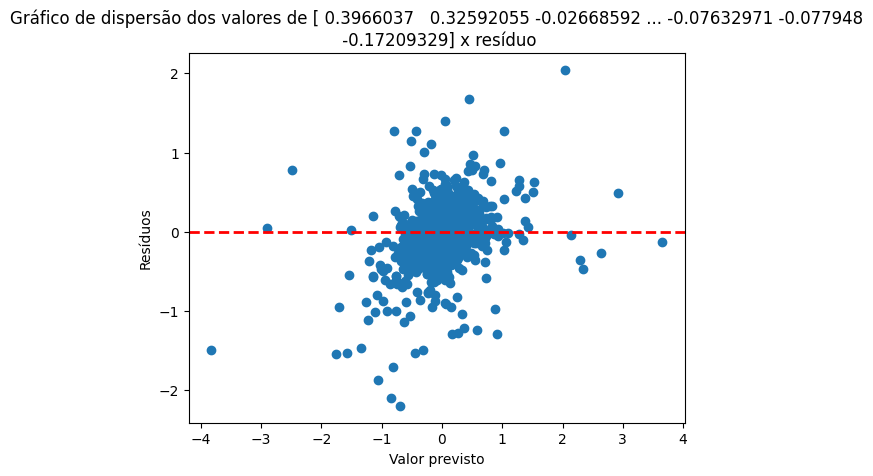

In [13]:
# análise gráfica da dispersão do resíduo com os dados de teste
grafico_analise_dispersao_residuo(y_pred=y_pred_xgb, res=res_xgb)

AttributeError: 'numpy.ndarray' object has no attribute 'name'

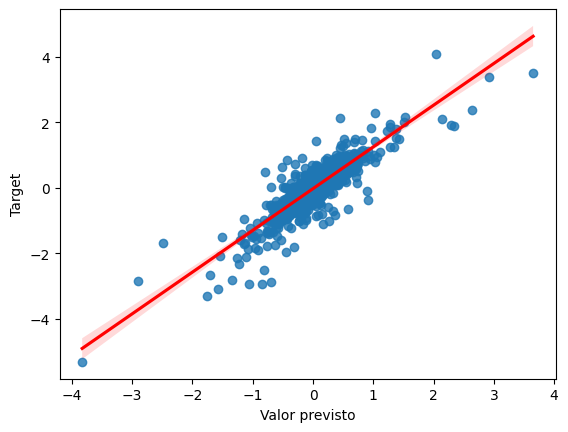

In [14]:
# análise gráfica da dispersão dos valores previstos com o target
grafico_analise_dispersao_target(y_pred=y_pred_xgb, target=y_teste)

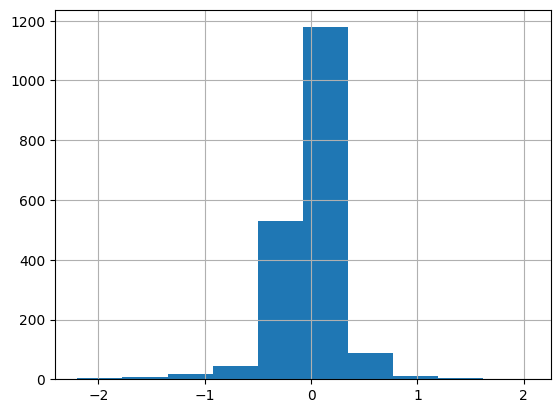

In [16]:
# histograma dos resíduos
res_xgb.hist();

In [ ]:
# gráfico qq plot dos resíduos


Random Forest

In [238]:
# construção do pipeline para o modelo Random Forest Regressor
model_rf = criar_pipeline(preprocessor=preprocessor, modelo_final=RandomForestRegressor())


2025-08-10 17:29:24,669 | INFO | src.model.train | Iniciando criação do pipeline completo.
2025-08-10 17:29:24,679 | INFO | src.model.train | ColumnTransformer(transformers=[('target_encoder', TargetEncoder(cols=['acao']),
                                 ['acao']),
                                ('cat_features',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['setor', 'industria', 'tipo']),
                                ('num_features',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('power...
                               

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

ts = TimeSeriesSplit(n_splits=5)

param_grid = {
    'modelo__n_estimators': [100, 200, 500],
    'modelo__max_depth': [5, 10, 20, 30, None],
    'modelo__min_samples_split': [2, 5, 10, 15],
    'modelo__min_samples_leaf': [1, 2, 4, 8],
    'modelo__max_features': ['sqrt', 'log2', 0.8, 1.0]
}

random = RandomizedSearchCV(estimator=model_xgb,
                          param_distributions=param_grid_xgb,cv=ts, 
                          n_iter=100, random_state=42, n_jobs=-1, verbose=5)


In [240]:
random.fit(X_treino, y_treino)
y_pred_rf = random.predict(X_teste)

c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [241]:
# avaliação de resultado
gerar_metricas(y_pred=y_pred_rf, y_true=y_teste)

MAE: 0.1621
RMSE: 0.3037
R2 Score: 0.6805


LIGHTGBM

In [7]:
import lightgbm as lgb

In [12]:
model_lgb = criar_pipeline(preprocessor=preprocessor, modelo_final=lgb.LGBMRegressor())


2025-08-15 21:52:07,315 | INFO | src.model.train | Iniciando criação do pipeline completo.
2025-08-15 21:52:07,323 | INFO | src.model.train | ColumnTransformer(transformers=[('target_encoder', TargetEncoder(cols=['acao']),
                                 ['acao']),
                                ('cat_features',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['setor', 'industria', 'tipo']),
                                ('num_features',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('power...
                               

In [15]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

ts = TimeSeriesSplit(n_splits=5)

param_grid_lgb = {
    'modelo__n_estimators': [500, 1000],
    'modelo__learning_rate': [0.1],
    'modelo__num_leaves': [31],
    'modelo__max_depth': [8, -1],
    'modelo__colsample_bytree': [0.8],
}

random = RandomizedSearchCV(estimator=model_lgb,
                          param_distributions=param_grid_lgb,cv=ts, 
                          n_iter=100, random_state=42, n_jobs=-1, verbose=5)

In [16]:
random.fit(X_treino, y_treino)
y_pred_lgb = random.predict(X_teste)

c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39475
[LightGBM] [Info] Number of data points in the train set: 10332, number of used features: 207
[LightGBM] [Info] Start training from score 0.023371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [17]:
# avaliação de resultado
gerar_metricas(y_pred=y_pred_lgb, y_true=y_teste)

MAE: 0.1673
RMSE: 0.3140
R2 Score: 0.6584


CATBOOST

In [ ]:
# construção do pipeline para o modelo Catboost
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
colunas_numericas = X_treino.select_dtypes(include=np.number).columns.tolist()
colunas_categoricas = ['acao','setor', 'industria','tipo']
todas_colunas = colunas_numericas + colunas_categoricas

ts = TimeSeriesSplit(n_splits=5)
# Verifique se as listas de colunas estão corretas
print(f"Colunas numéricas: {colunas_numericas}")
print(f"Colunas categóricas: {colunas_categoricas}")

# 2. Crie o pré-processador
preprocessor_catboost = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('norm', PowerTransformer(method='yeo-johnson')),
            ('scaler', StandardScaler())
        ]), colunas_numericas),
        ('cat', 'passthrough', colunas_categoricas)
    ],
    remainder='drop' # 'drop' para garantir que apenas as colunas que você especificou sejam usadas
)

# 3. Mapeie os índices das colunas categóricas APÓS a transformação
# O ColumnTransformer irá colocar as colunas numéricas primeiro, seguidas pelas categóricas
cat_features_indices = list(range(len(colunas_numericas), len(colunas_numericas) + len(colunas_categoricas)))
print(f"Índices das colunas categóricas para o CatBoost: {cat_features_indices}")

# 4. Instancie o modelo CatBoost
catboost_model = CatBoostRegressor(
    random_state=42, 
    verbose=0,
    cat_features=cat_features_indices)

# pipeline final
model_cb = criar_pipeline(preprocessor=preprocessor, modelo_final=catboost_model)

# 6. Dicionário de parâmetros para o RandomizedSearchCV

param_grid_catboost = {
    'model__iterations': [200, 500],
    'model__learning_rate': [0.05, 0.1],
    'model__depth': [6, 8],
    'model__verbose': [0]
}

# 7. Crie o objeto RandomizedSearchCV
random = RandomizedSearchCV(
    estimator=model_cb,
    param_distributions=param_grid_catboost,
    cv=ts, 
    n_iter=100, 
    random_state=42, 
    n_jobs=-1
)

Colunas numéricas: ['day_sin', 'day_cos', 'month_sin', 'month_cos', 'Volume_diff', 'Open_diff', 'High_diff', 'Low_diff', 'lag_1_close_diff', 'lag_3_close_diff', 'lag_5_close_diff', 'lag_7_Close_diff', 'lag_15_Close_diff', 'lag_30_Close_diff', 'lag_60_Close_diff', 'lag_90_Close_diff', 'rolling_mean_3_close_diff', 'volatility_3_close_diff', 'retorno_acumulado_3_close_diff', 'rolling_mean_5_close_diff', 'volatility_5_close_diff', 'retorno_acumulado_5_close_diff', 'rolling_mean_7_Close_diff', 'volatility_7_Close_diff', 'retorno_acumulado_7_Close_diff', 'rolling_mean_15_Close_diff', 'volatility_15_Close_diff', 'retorno_acumulado_15_Close_diff', 'rolling_mean_30_Close_diff', 'volatility_30_Close_diff', 'retorno_acumulado_30_Close_diff', 'rolling_mean_60_Close_diff', 'volatility_60_Close_diff', 'retorno_acumulado_60_Close_diff', 'rolling_mean_90_Close_diff', 'volatility_90_Close_diff', 'retorno_acumulado_90_Close_diff', 'lag_1_Volume_diff', 'lag_3_Volume_diff', 'lag_5_Volume_diff', 'lag_7_Vol

In [229]:
# ajuste e previsão do modelo
random.fit(X_treino, y_treino)
y_pred_cb = random.predict(X_teste)

c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [230]:
# avaliação de resultado
gerar_metricas(y_pred=y_pred_cb, y_true=y_teste)

MAE: 0.1561
RMSE: 0.2686
R2 Score: 0.7501


In [232]:
import pandas as pd

# Supondo que 'random_search_catboost' já foi treinado
# random_search_catboost.fit(X, y)

# 1. Obtenha o melhor modelo (o pipeline completo)
best_pipeline = random.best_estimator_

# 2. Obtenha o modelo CatBoost treinado dentro do pipeline
best_catboost_model = best_pipeline.named_steps['model']

# 3. Obtenha a importância das features
feature_importances = best_catboost_model.get_feature_importance()

# 4. Obtenha os nomes das features na ordem correta
# CatBoost lida com as features categóricas nativamente, então podemos pegar os nomes originais
# A ordem das features é a ordem em que elas são passadas para o modelo.
# No seu pipeline, o ColumnTransformer aplica a transformação e o remainder='passthrough'
# Então a ordem é: features numéricas (escaladas), seguidas pelas categóricas (sem codificação)

# Obtenha os nomes das colunas numéricas
numeric_features = best_pipeline.named_steps['preprocessor'].transformers_[0][2]
# Obtenha os nomes das colunas categóricas (que foram passadas através do preprocessor)
categorical_features = [col for col in X_treino.columns if col not in numeric_features]

feature_names = numeric_features + categorical_features

# 5. Crie um DataFrame para visualizar a importância das features
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# 6. Ordene o DataFrame pela importância de forma decrescente
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 7. Exiba o resultado
feature_importance_df.head(20)

,feature,importance
6,High_diff,23.310221
7,Low_diff,16.594466
154,macd,5.205395
5,Open_diff,3.931151
8,lag_1_close_diff,3.311515
142,volatility_15_Low_diff,2.387133
153,rsi,2.244780
113,volatility_15_High_diff,2.162441
29,volatility_30_Close_diff,1.818229
84,volatility_15_Open_diff,1.734733


# Teste para escolha do melhor modelo.



In [26]:
# ajuste de hiper-parâmetros do modelo
param_grid_xgb = {
    'modelo__n_estimators': [200, 500, 1000],
    'modelo__max_depth': [3, 5, 8, 10],
    'modelo__learning_rate': [0.01, 0.05, 0.1],
    'modelo__subsample': [0.7, 0.8, 1.0],
    'modelo__colsample_bytree': [0.7, 0.8, 1.0]
}

random = RandomizedSearchCV(estimator=model_xgb,param_distributions=param_grid_xgb,cv=ts, n_iter=100, 
                            random_state=42, verbose=5)

In [27]:
# validação do modelo
random.fit(X_treino, y_treino)
y_pred_ajustado = random.predict(X_teste)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END modelo__colsample_bytree=0.8, modelo__learning_rate=0.01, modelo__max_depth=8, modelo__n_estimators=1000, modelo__subsample=0.7;, score=0.667 total time=  14.9s
[CV 2/5] END modelo__colsample_bytree=0.8, modelo__learning_rate=0.01, modelo__max_depth=8, modelo__n_estimators=1000, modelo__subsample=0.7;, score=0.642 total time=  20.1s
[CV 3/5] END modelo__colsample_bytree=0.8, modelo__learning_rate=0.01, modelo__max_depth=8, modelo__n_estimators=1000, modelo__subsample=0.7;, score=0.181 total time=  24.3s
[CV 4/5] END modelo__colsample_bytree=0.8, modelo__learning_rate=0.01, modelo__max_depth=8, modelo__n_estimators=1000, modelo__subsample=0.7;, score=-9.154 total time=  20.8s
[CV 5/5] END modelo__colsample_bytree=0.8, modelo__learning_rate=0.01, modelo__max_depth=8, modelo__n_estimators=1000, modelo__subsample=0.7;, score=0.623 total time=  25.1s
[CV 1/5] END modelo__colsample_bytree=0.8, modelo__learning_rate=0

In [28]:
# métricas de ajuste do modelo
gerar_metricas(y_pred=y_pred_ajustado, y_true=y_teste)

MAE: 0.1625
RMSE: 0.3278
R2 Score: 0.6278


In [ ]:
param_grid_lgb= {
    'modelo__n_estimators': [200, 500, 1000],
    'modelo__learning_rate': [0.01, 0.05, 0.1],
    'modelo__num_leaves': [20, 31, 50],
    'modelo__max_depth': [-1, 8, 12],
    'modelo__min_child_samples': [20, 50],
    'modelo__subsample': [0.8, 1.0],
    'modelo__colsample_bytree': [0.8, 1.0],
}

In [48]:
# 1. Defina suas colunas
colunas_numericas = X_treino.select_dtypes(include=np.number).columns.tolist()
colunas_categoricas = ['acao','setor', 'industria','tipo']

# 2. Crie o pré-processador OTIMIZADO
# Ele só processa as colunas numéricas e passa as categóricas intactas
preprocessor_catboost = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('norm', PowerTransformer(method='yeo-johnson')),
            ('scaler', StandardScaler())
        ]), colunas_numericas),
        # As colunas categóricas são passadas sem transformação
        ('cat', 'passthrough', colunas_categoricas) 
    ],
    remainder='drop' 
)

# 3. Calcule os índices das colunas categóricas NA SAÍDA DO PRÉ-PROCESSADOR
# A saída do ColumnTransformer terá as colunas numéricas primeiro, depois as categóricas
cat_features_indices = list(range(len(colunas_numericas), len(colunas_numericas) + len(colunas_categoricas)))

# 4. Instancie o modelo CatBoost e passe os índices das colunas categóricas
catboost_model = CatBoostRegressor(
    random_state=42, 
    verbose=0,
    cat_features=cat_features_indices
)

# 5. Crie a pipeline final com as etapas corretas
model_cb = Pipeline(steps=[
    ('preprocessador', preprocessor_catboost),
    ('modelo', catboost_model)
])

# 6. Dicionário de parâmetros para o RandomizedSearchCV
param_grid_catboost = {
    'modelo__iterations': [500, 1000, 2000],
    'modelo__learning_rate': [0.01, 0.05, 0.1],
    'modelo__depth': [4, 6, 8, 10],
    'modelo__l2_leaf_reg': [1, 3, 5, 7, 9],
    'modelo__verbose': [0]
}

# 7. Crie e execute o objeto RandomizedSearchCV
ts = TimeSeriesSplit(n_splits=5)
random = RandomizedSearchCV(
    estimator=model_cb,
    param_distributions=param_grid_catboost,
    cv=ts, 
    n_iter=100, 
    random_state=42)

random

,estimator,Pipeline(step...D03309C290>)])
,param_distributions,"{'modelo__depth': [4, 6, ...], 'modelo__iterations': [500, 1000, ...], 'modelo__l2_leaf_reg': [1, 3, ...], 'modelo__learning_rate': [0.01, 0.05, ...], ...}"
,n_iter,100
,scoring,None
,n_jobs,None
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
# previsap do modelo
random.fit(X_treino, y_treino)


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import 

In [57]:
y_pred_ajustado = random.predict(X_teste)

NotFittedError: This RandomizedSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [56]:
# métricas de ajuste do modelo
gerar_metricas(y_pred=y_pred_cb_ajustado, y_true=y_teste)

NameError: name 'y_pred_cb_ajustado' is not defined